In [1]:
import os
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

last_good_frame = 8

In [2]:
activations_dir = "flyvis/parsed_objects"
activations = np.load(os.path.join(activations_dir, "decoding_activations.npy"), allow_pickle=True)

tmy18 = torch.stack([torch.swapaxes(a["TmY18"], 1, 2).squeeze(0) for a in activations]).to(device)

In [4]:
from retina_to_connectome import get_voronoi_averages
n_centers = 1200
avgs = get_voronoi_averages(tmy18[0, :, -8].cpu(), n_centers=n_centers)

In [5]:
avgs

array([ 77.87974 , 120.63897 , 124.733116, ..., 107.38901 ,  64.06555 ,
       103.69228 ], dtype=float32)

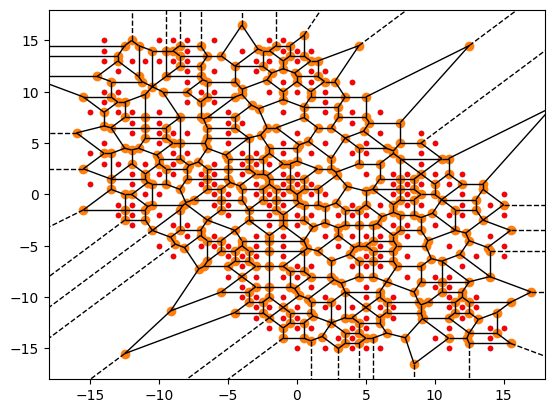

In [7]:
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Create Voronoi Diagram
vor = Voronoi(rand_points)

# Plot Voronoi diagram (optional, for visualization)
voronoi_plot_2d(vor)
plt.plot(rand_points[:, 0], rand_points[:, 1], 'r.')
plt.show()


In [12]:
from scipy.spatial import cKDTree

# Create a KD-tree for fast lookup of nearest Voronoi cell
tree = cKDTree(rand_points)

# Find the nearest Voronoi cell for each point in the lattice
_, indices = tree.query(coords)

# Compute the average value for each Voronoi cell
averages = np.array([tmy18[0, :, -last_good_frame].cpu()[indices == i].mean() for i in range(n)])


In [13]:
averages

array([116.97298 , 109.02668 , 111.102844,  78.85175 , 117.5184  ,
       117.33312 , 114.89924 , 124.60326 ,  99.38789 ,  61.418766,
       101.655495, 110.91184 , 120.889145, 114.03546 , 113.55567 ,
       121.61759 , 116.38338 , 117.296616, 120.41138 , 107.928604,
       117.93574 ,  98.25314 , 115.29621 , 117.521095, 116.55517 ,
       118.181725, 102.37038 , 123.88898 , 117.022995, 117.9445  ,
       118.545654, 112.59893 , 119.96866 , 115.52033 ,  94.29818 ,
       117.83637 ,  94.97443 ,  88.00808 ,  85.05507 , 118.12598 ,
        68.54796 , 122.16911 , 116.67932 ,  70.41545 , 102.14457 ,
       116.851944, 109.7692  , 118.40689 , 117.48704 , 118.58366 ,
        78.03197 , 104.220024, 118.200294, 114.226494, 118.24007 ,
       116.877235,  96.503395, 124.13975 , 117.47184 , 117.124794,
       118.38397 , 119.28201 , 117.56189 , 101.39046 , 113.58572 ,
       113.84555 , 116.54592 , 118.15127 ,  85.85293 , 117.20804 ,
       118.243164, 120.253395, 116.31455 , 118.35225 , 115.305